In [1]:
import numpy as np
import helpers_and_variables as hlp
import nlp as nlp_hlp
import ML_helpers as ml_hlp
import shap
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import pixiedust
# %%pixie_debugger

In [2]:
## Extract dicts with patients scenarios
# the main file of data
dataPath = ".../PekLUng.xlsx"
password = None#
rawdataDF = hlp.get_exL_df(stringPath=dataPath, password=password, sheetNum=1)
rawdataDF = rawdataDF.iloc[1: , :]
# The file with decoding information
dataInfoPath = ".../Datainformation.xlsx"
dataInfoDF = hlp.get_cleaned_dataInfo_df(dataInfoPath)
katInfoDF = hlp.get_cleaned_katInfo_df(dataInfoPath)
dict_of_katInfo = hlp.get_dict_of_katInfoDF(katInfoDF)
dict_of_dataInfo = hlp.get_dict_of_dataInfoDF(dataInfoDF)
""" 
Get the labels, under name Lungcancer_Num
check whether labels are 1=yes LC or 2=No LC and check STUDY_1 if valid, remove unlabeled and invalid patients

"""
rawdataDF, labels = hlp.get_labels_and_indices_unlabeled_patients(rawdataDF)

"""
Remove features, which includes information about the label, like diagnos2, aslo modules names
DiagnosticInvestigation (need to be discussed, since it includes dignostic which means non early prediction).
columns_tobe_removed=None --> predefind columns will be removed, see the function in helpers_and_variables file.
remove_cols_with_dates=True --> removes all columns with dates(this is relevance in case of tfidf), 
otherwise consider using converting dates to days, see function hlp.get_dates_in_days() in next cell.
"""
copy_rawdata =  hlp.get_dataframe_without_cols(rawdataDF, columns_tobe_removed=None)

# 70 variabels
levitsky_rawdata = hlp.get_dataframe_with_specific_cols(rawdataDF)

# 7b set
backgroud_variables = levitsky_rawdata[levitsky_rawdata.columns[0:8]]

# 63de set
descriptors = levitsky_rawdata[levitsky_rawdata.columns[8:]]
descriptors.insert(0, column=levitsky_rawdata.columns[0], value=levitsky_rawdata[levitsky_rawdata.columns[0]],
                   allow_duplicates=False)

In [ ]:
##############################################
## For each data set, get scenarios and save as dict
data_sets = ['dict_all', 'dict_70V', 'dict_63D', 'dict_7B']
data_sets_to_clean = [copy_rawdata, levitsky_rawdata, descriptors, backgroud_variables]
i = 0
for data_frame_to_clean in data_sets_to_clean:
    main_dict, ind_num_removed_features = hlp.get_dict_of_questions_answers(data_frame_to_clean, 
                                                                            dataInfoDF, 
                                                                            katInfoDF, 
                                                                            amount_data =None ,
                                                                            clear_missings_or_Non=True,
                                                                            clear_ques_with_negative_answeres=False)
    max_num_feature_removed = 0
    ind_of_max_feature_removed = 0

    for ind, count in ind_num_removed_features:
        if count > max_num_feature_removed:
            max_num_feature_removed = count
            ind_of_max_feature_removed = ind
    print("Most number of features removed from a patient is: ", max_num_feature_removed)
    print("Patient index with most removed features is: ", ind_of_max_feature_removed)
    print("Patient number or id: {0}, with remaining number of features: {1}".format(str(int(data_frame_to_clean.iloc[ind_of_max_feature_removed][0])), len(main_dict[str(int(data_frame_to_clean.iloc[ind_of_max_feature_removed][0]))])))
    print("\nTotal length of the main dictionary, number of patients: ", len(main_dict))

    #############################################
    ## save scenarios in json dict
    dict_path = ".../" + str(data_sets[i])
    hlp.write_dict_as_json_file(main_dict, dict_path)
    i+=1

In [ ]:
## Visulize data 

copy_rawdata = pd.DataFrame.copy(rawdataDF)

# education
df2 = pd.DataFrame(10*np.random.randn(len(copy_rawdata), 1))
df2['Education_cat'] = copy_rawdata['Q2'].values

conds = [df2.values == 2, df2.values == 3,  df2.values == 4 , df2.values == 5]
choices = ['Annat', 'Grundskola', 'Gymnasium', 'Universitet']

df2 = pd.DataFrame(np.select(conds, choices, default='unknown'),
             index=range(0, len(copy_rawdata)),
             columns=df2.columns)

# Age
df2['Age_cat'] = copy_rawdata['Age'].values
conds = [df2['Age_cat'].values <= 40.0 , df2['Age_cat'].values <= 65.0, 
         df2['Age_cat'].values <= 85.0 , df2['Age_cat'].values > 85.0]
choices = ['under40Years', '40To65Years', '65To85Years', 'Over85Years']

tmp = pd.DataFrame(np.select(conds, choices, default='unknown'),
             index=range(0, len(copy_rawdata)),
             columns=['Age_cat'])
df2['Age_cat'] = tmp['Age_cat']

df2['Age'] = copy_rawdata['Age'].values.astype('float')

# living
df2['Living situation'] = copy_rawdata['Q1d'].values 
conds = [df2['Living situation'].values == 1 , df2['Living situation'].values == 2]
choices = ['not living alone', 'living alone']

tmp = pd.DataFrame(np.select(conds, choices, default='unknown'),
             index=range(0, len(copy_rawdata)),
             columns=['Living situation'])
df2['Living situation'] = tmp['Living situation']

# work 
del tmp
tmp1 = copy_rawdata[['Q4a', 'Q4b', 'Q4c', 'Q4d', 'Q4e', 'Q4f']]
conds = [tmp1['Q4a'].values == 2 , tmp1['Q4b'].values == 2, tmp1['Q4c'].values == 2, 
         tmp1['Q4d'].values == 2,tmp1['Q4e'].values == 2 , tmp1['Q4f'].values == 2]
choices = ['full', 'partly', 'no work', 'study', 'pension', 'on sick']

tmp = pd.DataFrame(np.select(conds, choices, default='other'),
             index=range(0, len(copy_rawdata)),
             columns=['Work situation'])
df2['Work situation'] = tmp['Work situation']

# smoking
del tmp, tmp1
tmp1 = copy_rawdata[['Q9', 'Smoking']]

conds = [tmp1['Q9'].values == 1, tmp1['Q9'].values == 2 , tmp1['Q9'].values == 3, 
         tmp1['Q9'].values == 4, tmp1['Q9'].values == 5]
choices = ['unknown', 'never', 'other', 'used to', 'still']

tmp = pd.DataFrame(np.select(conds, choices, default='unknown'),
             index=range(0, len(copy_rawdata)),
             columns=['Smoking situation'])
df2['Smoking situation'] = tmp['Smoking situation']

indexes = np.where(copy_rawdata['Smoking'].values != copy_rawdata['Q9'].values)
df2.loc[indexes[0]+1, 'Smoking situation'] = 'quit 1 year ago'
# df2.loc[(tmp1['Q9'].values == 4) and (tmp1['Smoking'].values == 5), 'Smoking situation'] = 'quit 1 year ago'

df2['label'] = labels.values
df2.loc[df2['label'] == 1, 'label'] = 'cancer'; 
df2.loc[df2['label'] == 2, 'label'] = 'no cancer'

df2['Gender'] = copy_rawdata['Gender'].values # 0 female, 1 male
df2.loc[df2['Gender'] == 0, 'Gender'] = 'female';df2.loc[df2['Gender'] == 1, 'Gender'] = 'male'

df2.drop(columns=[0], inplace=True)
df2

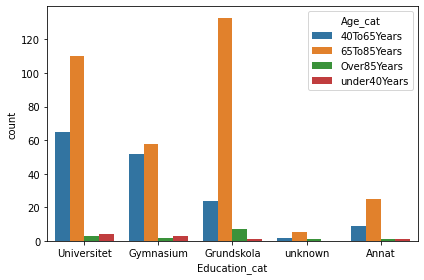

In [182]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Education_cat", hue="Age_cat", data=df2)
plt.tight_layout()

save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/count_education_ageCat"+".pdf"
plt.savefig(file_path)

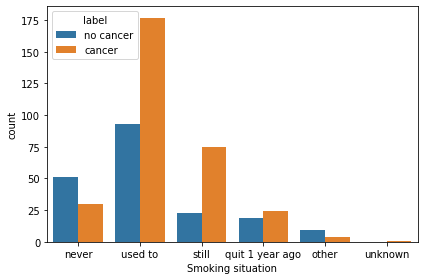

In [170]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Smoking situation", hue="label", data=df2)
plt.tight_layout()

save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/count_smoking_label"+".pdf"
plt.savefig(file_path)

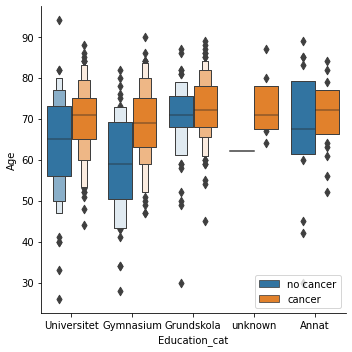

In [183]:
ax = sns.catplot(data=df2, kind='boxen', x="Education_cat", y="Age", hue="label", legend=False, margin_titles=True)
plt.tight_layout()
plt.legend(loc='lower right')
save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/age_education_label"+".pdf"
plt.savefig(file_path)

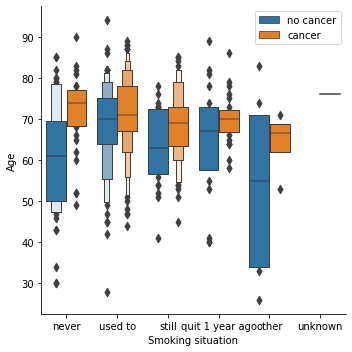

In [187]:
ax = sns.catplot(data=df2, kind='boxen', x="Smoking situation", y="Age", hue="label", legend=False, margin_titles=True)
plt.tight_layout()
plt.legend()#loc='lower right')
save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/age_smoke_label"+".pdf"
plt.savefig(file_path)

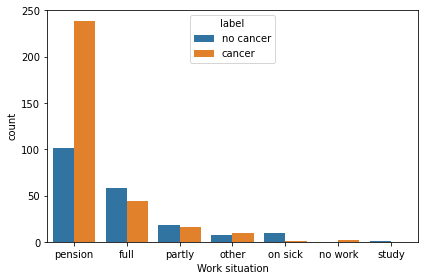

In [117]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Work situation", hue="label", data=df2)
plt.tight_layout()

save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/count_work_label"+".pdf"
plt.savefig(file_path)

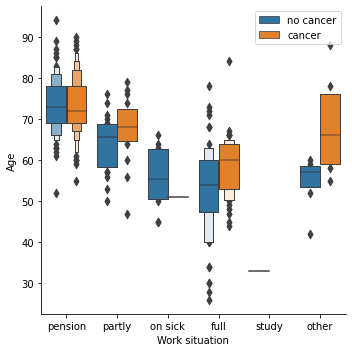

In [6]:
ax = sns.catplot(data=df2, kind='boxen', x="Work situation", y="Age", hue="label", legend=False, margin_titles=True,
                order=['pension', 'partly', 'on sick', 'full', 'study', 'other'])
plt.tight_layout()
plt.legend()#loc='lower right')
save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/age_work_label_box"+".pdf"
plt.savefig(file_path)

In [112]:
df1 = pd.DataFrame(data=labels.values, columns=['label'])

df1['Age'] = copy_rawdata['Age'].values.astype('float')
df1['Gender'] = copy_rawdata['Gender'].values # 0 female, 1 male
df1.loc[df1['Gender'] == 0, 'Gender'] = 'female';df1.loc[df1['Gender'] == 1, 'Gender'] = 'male'
df1.loc[df1['label'] == 1, 'label'] = 'cancer'; 
df1.loc[df1['label'] == 2, 'label'] = 'no cancer'
df1['Age_cat'] = df2['Age_cat']

# conds = [df1['Gender'].values <= 40.0 , df1.values <= 65.0,  df1.values <= 85.0 , df1.values > 85.0]
# sns.catplot(data=df1)
sns.countplot(data=df1, x='label')

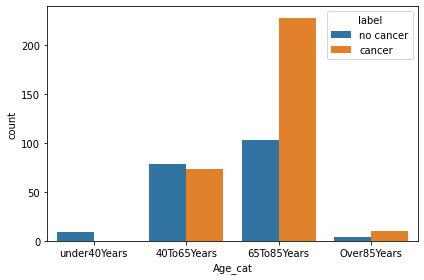

In [116]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Age_cat", hue="label", data=df1, order=choices)
plt.tight_layout()
save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/count_ageCat_labe"+".pdf"
plt.savefig(file_path)

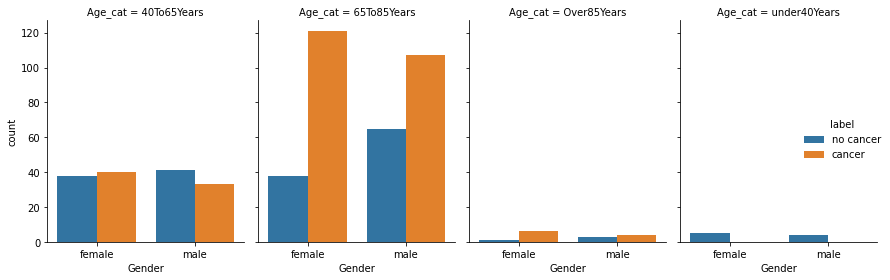

In [127]:
ax = sns.catplot(x="Gender", hue="label", col="Age_cat",
                data=df1, kind="count",
                height=4, aspect=.7)
#  sns.countplot(x="Age_cat", y="Gender", hue="label", data=df1, order=choices)
plt.tight_layout()
save_file_name = r"...\data_imgs\data_plots"
file_path = save_file_name + r"/count_ageCat_label_gender"+".pdf"
plt.savefig(file_path)

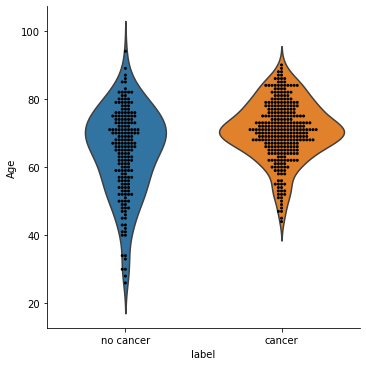

In [99]:
g = sns.catplot(x="label", y="Age", kind="violin", inner=None, data=df1)
sns.swarmplot(x="label", y="Age", color="k", size=3, data=df1, ax=g.ax)